# FOCuS fast algorithm implementation for Poisson data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

In [2]:
class Curve:
    def __init__(self, k_T, lambda_1, t=-1):
        self.a = k_T
        self.b = -lambda_1
        self.t = t
        ## a log(mu) + b(mu-1)
        ## t contains time offset, because lambda_1 is incorporated into b.
    
    def __repr__(self):
        return f'{self.a}log(μ)-{-self.b}(μ-1), t={self.t}.'
    
    def evaluate(self, mu):
        return np.maximum(self.a*np.log(mu) + self.b*(mu-1), 0)
    
    def update(self, k_T, lambda_1):
        return Curve(self.a + k_T, -self.b + lambda_1, self.t-1)
    
    def ymax(self):
        return self.evaluate(self.xmax())
    
    def xmax(self):
        if self.a==0 and self.b==0:
            return 0
        else:
            return -self.a/self.b
    
    def is_negative(self):
        #returns true if slope at mu=1 is negative (i.e. no evidence for positive change)
        return (self.a + self.b) < 0
    
    def dominates(self, other_curve):
        self_root = -self.a/self.b #other non mu=1 root: the curve's "length"
        other_root = -other_curve.a/other_curve.b
        self_slope = self.a + self.b  #slope at mu=1: the curve's "height"
        other_slope = other_curve.a + other_curve.b
        return (self_root > other_root)and(self_slope > other_slope)
    
    def __add__(self, other_curve):
        #addition
        return Curve(self.a+other_curve.a, -self.b-other_curve.b, self.t+other_curve.t)
    
    def __sub__(self, other_curve):
        #subtraction
        return Curve(self.a-other_curve.a, -self.b+other_curve.b, self.t-other_curve.t)

In [3]:
def focus_step_fast_poisson(curve_difference_list, final_curve, max_list, X_t, λ, threshold=12.5, min_parameter=1):
    #min_parameter = log(μ_min)/(1- μ_min), avoids having to calculate logarithms
    
    #starting values:
    #curve_difference_list = []
    #final_curve = Curve(0, 0, t=0)
    #max_list = [0]

    pruning_required = True
    maxima_required = True
    threshold_met = False

    #start by performing an update:
    if -X_t*final_curve.b > λ*final_curve.a:
        #add another curve on
        new_final_curve = Curve(X_t, λ)
        curve_difference_list.append(final_curve)
        max_list.append(max_list[-1] + final_curve.ymax()) #requires evaluating a logarithm
        pruning_required=False
    else:
        #just update the final curve
        new_final_curve = final_curve.update(X_t, λ)


    while pruning_required:#check if curves prune each other out

        if curve_difference_list: #nonempty
            second_to_last_curve = new_final_curve+curve_difference_list[-1]
            if second_to_last_curve.dominates(new_final_curve):
                #prune out
                curve_difference_list.pop()
                max_list.pop()
                new_final_curve = second_to_last_curve
            else:
                #no more pruning checks required
                pruning_required=False
        
        else: pruning_required=False
            
    #evaluate whether rightmost curve is only nonzero on  1 < μ <  μ_min (min_parameter=1 corresponds to μ_min=1)
    if (new_final_curve.a * min_parameter < -new_final_curve.b):
        #empty out the algorithm
        curve_difference_list=[]
        max_list=[0]
        new_final_curve = Curve(0, 0, t=0)
        maxima_required=False
                
    #check maximum
    i = 1
    curve_being_checked = new_final_curve
    while maxima_required:
        
        curve_max = curve_being_checked.ymax() #requires evaluating a logarithm

        if curve_max+max_list[-i] < threshold:
            #no curve maxima meets the threshold
            maxima_required = False

        elif curve_max >= threshold:
            threshold_met=True
            maxima_required=False

        else: #iterate leftwards through curve list
            curve_being_checked = curve_being_checked + curve_difference_list[-i]
            i += 1

    return curve_difference_list, new_final_curve, max_list, threshold_met    
        
from copy import copy
def interpret(curve_difference_list, final_curve):
    #Takes the internals of the fast FOCuS algorithm and re-interprets them in the same format as the internals of the basic FOCuS algorithm
    global_max=final_curve.ymax()
    time_offset=final_curve.t
    curve_list=[final_curve]
    curve_being_checked = final_curve
        
    for i in range(1, len(curve_difference_list)+1):
        curve_being_checked = curve_being_checked + curve_difference_list[-i]
        
        curve_list.append(copy(curve_being_checked))
        
        if curve_being_checked.ymax() > global_max:
            global_max = curve_being_checked.ymax()
            time_offset = curve_being_checked.t
    curve_list.reverse()
    
    return curve_list, global_max, time_offset

def plot_curves(curve_list, threshold=25, t=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS Step")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{t}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+t+1}$')
    
    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

In [4]:
def focus_fast_poisson(X, λ, μ_min=1, threshold=12.5, plot=False):
    
    if μ_min==1:
        min_parameter=1
    else:
        min_parameter = log(μ_min)/(μ_min-1)
    curve_difference_list=[]
    max_list=[0]
    final_curve=Curve(0, 0, t=0)
    
    if np.ndim(λ)==0:#scalar
        λ = np.full(X.shape, λ)
    
    for t in range(len(X)):
        curve_difference_list, final_curve, max_list, threshold_met  = focus_step_fast_poisson(curve_difference_list,
                                                                                       final_curve,
                                                                                       max_list,
                                                                                       X[t], λ[t],
                                                                                       threshold,
                                                                                       min_parameter)
        
        #print(curve_difference_list)
        
        if plot:
            clear_output(wait=True)
            curve_list, global_max, time_offset = interpret(curve_difference_list, final_curve)
            upper_bound = max_list[-1] + final_curve.ymax()
            plot_curves(curve_list, threshold=threshold, t=t)
            plt.hlines(upper_bound, xmin=1, xmax=4, color="black")
            plt.show()
            #print(curve_list)
        
        #print(max_list)
        if threshold_met:
            curve_list, global_max, time_offset = interpret(curve_difference_list, final_curve)
            significance, changepoint, stopping_time = global_max, t+time_offset+1, t
            return significance, changepoint, stopping_time
    
    return 0, None, len(X)+1

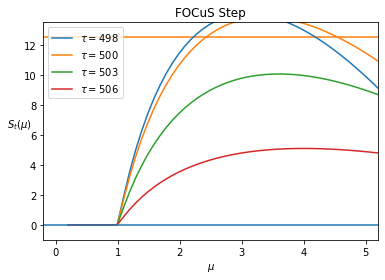

In [11]:
np.random.seed(42)
threshold=12.5
X = np.concatenate((stats.poisson(mu=1).rvs(size=500), stats.poisson(mu=4).rvs(size=50)))
significance, changepoint, stopping_time = focus_fast_poisson(X, λ=1, μ_min=1, threshold=12.5, plot=True)

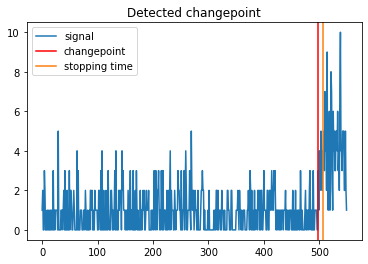

In [12]:
plt.plot(X)
plt.title("Detected changepoint")
if changepoint is not None:
    plt.axvline(changepoint, color='red')
    plt.axvline(stopping_time, color='C1')
    plt.legend(['signal','changepoint', 'stopping time'])